In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 31)
(17248, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_RR_swing = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_RR_swing = Y_footsteps_accelerations_absolute[idxs]

## Predict FL foot -> x

In [8]:
X_footsteps_accelerations_absolute_RR_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.11232672, -0.02118164, -0.00713002,  0.04701474,
        0.22752666,  0.13133161, -0.3802225 ,  0.2578249 , -0.12791809,
       -0.37706181, -0.24075544,  0.12229743, -0.38356426, -0.26876706,
       -0.12459208, -0.38188431,  0.09097511,  0.01569571,  0.03546102,
       -0.07442539,  0.09544686, -0.01419668,  0.00986535,  1.        ,
        0.        ])

In [9]:
Y_footsteps_accelerations_absolute_RR_swing[0, :]

array([ 0.05770308, -0.0106103 ,  0.05375661, -0.00291052])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RR_swing[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_RR_swing[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_RR_swing[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_RR_swing[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_RR_swing[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_RR_swing[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RR_swing[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9982758894681008
RMSE:  0.007620360878549667
The lowest error is:  8.938991393203644e-06
The highest error is:  0.028044839824908907
The avg. error is:  0.005647684745380231


In [12]:
model_rr_relative_swinging_x.coef_

array([[ 0.00580415,  0.02782015,  0.44224174, -0.66931282,  0.14647178,
        -0.49006852,  0.14150115,  0.51284002, -0.11883361, -0.25752218,
        -0.35263594]])

In [13]:
model_rr_relative_swinging_x.intercept_

array([0.31415006])

Text(0, 0.5, 'Predictions')

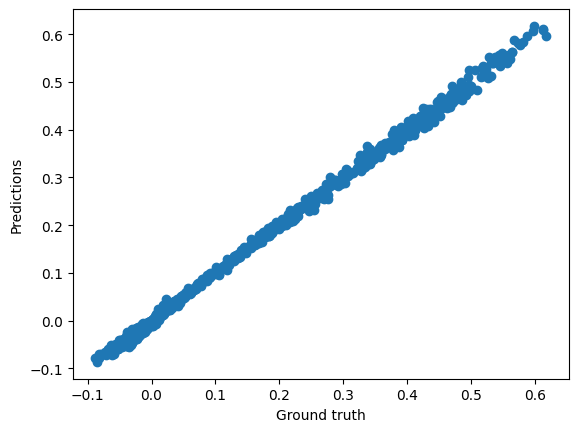

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RR foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RR_swing[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_RR_swing[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_RR_swing[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_RR_swing[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_RR_swing[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_RR_swing[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RR_swing[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9271821415126066
RMSE:  0.007228467501613014
The lowest error is:  9.436417876903906e-06
The highest error is:  0.026110091331840505
The avg. error is:  0.005431065683529161


In [17]:
model_rr_relative_swinging_y.coef_

array([[ 0.00845576, -0.01507626,  0.06071777,  0.139385  , -1.69421209,
         0.23205075,  0.55351303, -0.42233337,  0.19220614, -0.1531297 ,
        -0.35902625]])

In [18]:
model_rr_relative_swinging_y.intercept_

array([-0.02091745])

Text(0, 0.5, 'Predictions')

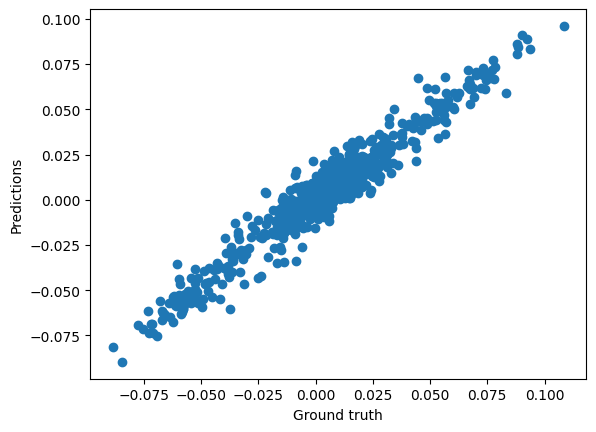

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')